In [203]:
# conda activate chronocell

import os
import sys
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath("code"))
from protein_from_RNA import *

# sys.path.append("/mnt/lareaulab/reliscu/programs/FGP_2024")
# import Chronocell
# from Chronocell.inference import Trajectory
# from Chronocell.mixtures import PoissonMixtureSS
# from Chronocell.utils import *
# from Chronocell.plotting import *
# from Chronocell.models.two_species_ss import get_Y

In [3]:
random_seed = 0

# Set parameter values

In [4]:
# ==== Transcription rate ====
alpha_mu = 2 # (Corresponds to ~7 mRNAs/hour, per Chronocell paper)
alpha_sd = 1

# === Splicing rate ===
beta_mu = 2 # np.log(splicing_rate) # (Corresponds to ~8.5 minute splicing rate, per Chronocell paper)
beta_sd = 0.5

# === mRNA degradation rate ===
gamma_mu = 0.5 # (Corresponds to ~2.8 hour half-life, per Chronocell paper)
gamma_sd = 0.5

# === Translation rate === 
median_transl_rate = 30 # (per Jovanovic paper)
transl_rate_mu = np.log(median_transl_rate) # Median of lognormal
transl_rate_sd = 1

# === Protein degradation rate === 
protein_deg_rate = .01 # (per Jovanovic paper)
protein_deg_rate_mu = np.log(protein_deg_rate) # Median of lognormal
protein_deg_rate_sd = 1.5

# Simulate data

In [258]:
# Simulate data

n = 1000 # No. cells per lineage
p = 500 # No. genes
topo = np.array([[0, 1, 2], [0, 1, 3]])
tau = (0, 2, 6)

theta = get_RNA_params(topo, p, alpha_mu, alpha_sd, beta_mu, beta_sd, gamma_mu, gamma_sd, random_seed=random_seed)
phi = get_protein_params(p, transl_rate_mu, transl_rate_sd, protein_deg_rate_mu, protein_deg_rate_sd, random_seed=random_seed)
Y_observed, Y, theta, rd, true_t, true_l = simulate_RNA(topo, tau, theta, n, random_seed=random_seed)
P_observed, P = simulate_protein_from_RNA(Y_observed, topo, true_t, true_l, phi, random_seed=random_seed)

## What is unspliced/spliced RNA ratio?

In [261]:
Y_observed[:, :, 0]

array([[16, 16,  0, ...,  1,  3,  6],
       [11, 16,  3, ...,  0,  1,  7],
       [16, 12,  2, ...,  0,  3,  7],
       ...,
       [20,  2,  6, ...,  0,  0,  0],
       [20,  3,  4, ...,  0,  1,  1],
       [17,  0,  5, ...,  0,  1,  0]])

In [262]:
Y_observed[:, :, 1]

array([[59, 23,  1, ...,  1, 29, 19],
       [58, 25,  3, ...,  0, 28, 19],
       [54, 17,  3, ...,  5, 38, 21],
       ...,
       [89,  3,  7, ...,  6, 10,  2],
       [80,  3,  6, ...,  3, 11,  0],
       [71,  1,  9, ...,  4, 13,  1]])

In [263]:
np.nanmedian(Y_observed[:, :, 0]/Y_observed[:, :, 1])

/tmp/ipykernel_3369928/845268906.py:1: RuntimeWarning: divide by zero encountered in divide
  np.nanmedian(Y_observed[:, :, 0]/Y_observed[:, :, 1])
/tmp/ipykernel_3369928/845268906.py:1: RuntimeWarning: invalid value encountered in divide
  np.nanmedian(Y_observed[:, :, 0]/Y_observed[:, :, 1])


np.float64(0.16666666666666666)

# Visualize RNA and protein trajectory

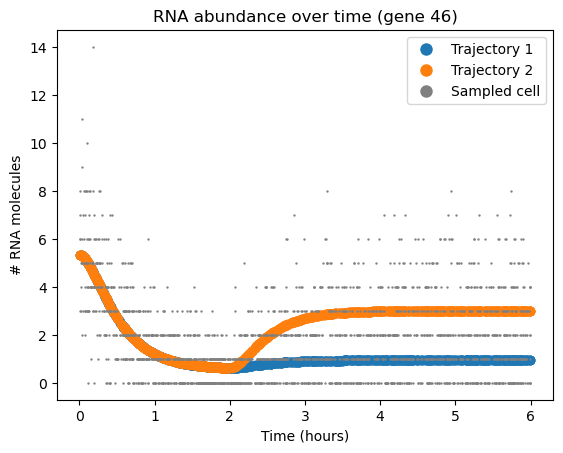

In [264]:
idx = 46
mask_0 = true_l == 0
mask_1 = true_l == 1

# Plot example RNA trajectory

plt.scatter(true_t[mask_0], Y[mask_0, idx, 1])
plt.scatter(true_t[mask_1], Y[mask_1, idx, 1])
plt.scatter(true_t, Y_observed[:, idx, 1], s=.5, color="gray")

plt.xlabel("Time (hours)");
plt.ylabel("# RNA molecules")
plt.title(f"RNA abundance over time (gene {idx})");

custom_handles = [
    Line2D([0], [0], marker='o', color='w', label='Trajectory 1', markerfacecolor='tab:blue', markersize=10),  # big marker
    Line2D([0], [0], marker='o', color='w', label='Trajectory 2', markerfacecolor='tab:orange', markersize=10), # small marker
    Line2D([0], [0], marker='o', color='w', label='Sampled cell', markerfacecolor='gray', markersize=10)  # tiny marker
]
plt.legend(handles=custom_handles)

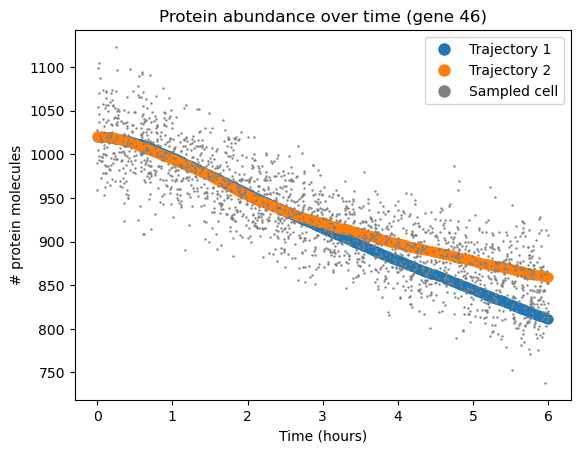

In [266]:
# === Plot example protein trajectory for same gene ===
plt.scatter(true_t[mask_0], P[mask_0, idx], color='tab:blue', label='Trajectory 1')
plt.scatter(true_t[mask_1], P[mask_1, idx], color='tab:orange', label='Trajectory 2')
plt.scatter(true_t, P_observed[:, idx], s=.5, color="grey", label="Sampled cells")

plt.xlabel("Time (hours)");
plt.ylabel("# protein molecules")
plt.title(f"Protein abundance over time (gene {idx})");

custom_handles = [
    Line2D([0], [0], marker='o', color='w', label='Trajectory 1', markerfacecolor='tab:blue', markersize=10),  # big marker
    Line2D([0], [0], marker='o', color='w', label='Trajectory 2', markerfacecolor='tab:orange', markersize=10), # small marker
    Line2D([0], [0], marker='o', color='w', label='Sampled cell', markerfacecolor='gray', markersize=10)  # tiny marker
]
plt.legend(handles=custom_handles)

# PCA on cells 

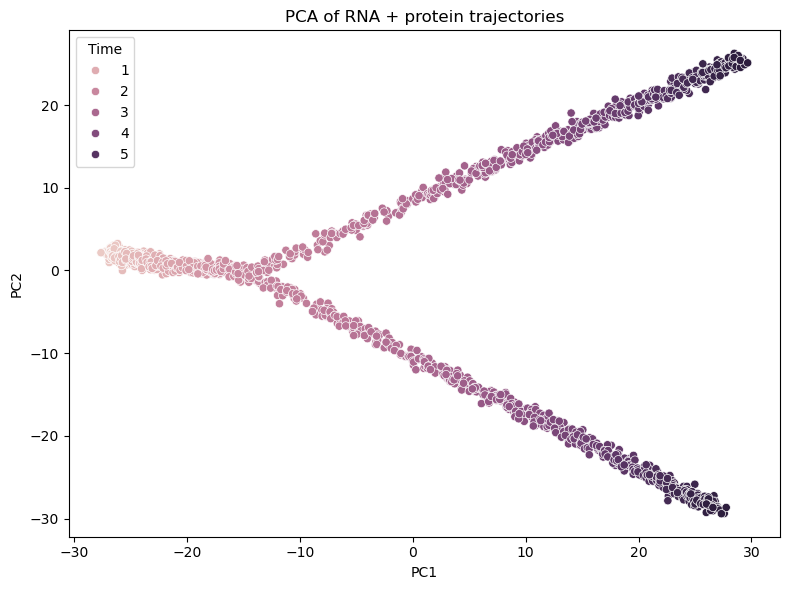

In [267]:
# PCA on cells 

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Y_norm = stats.zscore(Y_observed[:, :, 1]) # Z-score each gene (column)
P_norm = stats.zscore(P_observed)

# Concatenate RNA and protein for PCA
combined_traj = np.concatenate([Y_norm, P_norm], axis=1)
pca = PCA(n_components=2)
traj_pca = pca.fit_transform(combined_traj)

meta = pd.DataFrame()
meta['PC1'] = traj_pca[:, 0]
meta['PC2'] = traj_pca[:, 1]
meta['Time'] = true_t

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=meta, hue='Time')
plt.title('PCA of RNA + protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

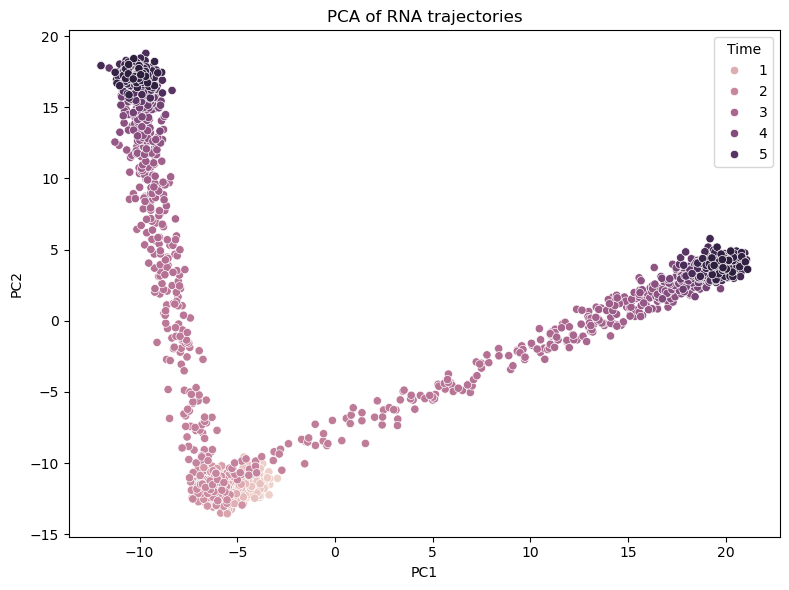

In [268]:
# === RNA for PCA ===
combined_traj = Y_norm
pca = PCA(n_components=2)
traj_pca = pca.fit_transform(combined_traj)

meta = pd.DataFrame()
meta['PC1'] = traj_pca[:,0]
meta['PC2'] = traj_pca[:,1]
meta['Time'] = true_t

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=meta, hue='Time')
plt.title('PCA of RNA trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

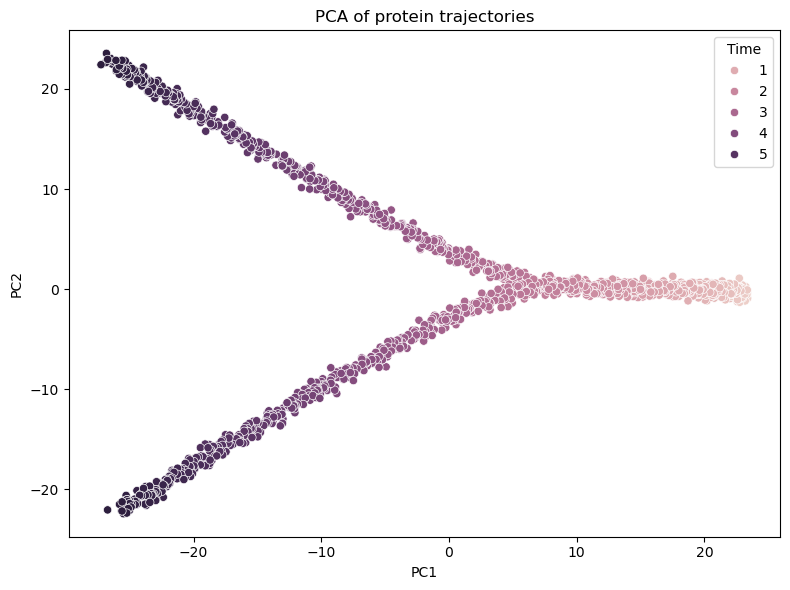

In [269]:
# === Protein for PCA ===
combined_traj = P_norm
pca = PCA(n_components=10)
traj_pca = pca.fit_transform(combined_traj)

meta = pd.DataFrame()
meta['PC1'] = traj_pca[:,0]
meta['PC2'] = traj_pca[:,1]
meta['Time'] = true_t

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=meta, hue='Time')
plt.title('PCA of protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

# Calculate RNA vs. protein correlation

In [270]:
# Calculate RNA vs. protein correlation for each gene per trajectory

rows = []
for i in range(p):
    y_i = Y_observed[:, i, 1]
    p_i = P_observed[:, i]
   
    RNA_steady_state = theta[i, 0]
    alpha_vals = theta[i, 1:-2]  # All columns after steady_state up to beta
    beta = theta[i, -2]
    gamma = theta[i, -1]
    
    protein_steady_state = phi[i, 0]/phi[i, 1]
    
    cor_vals = []
    for l in set(true_l):
        mask = true_l == l
        cor_vals.append(np.corrcoef(y_i[mask], p_i[mask])[0, 1])
        
    row = {
        'Cor': np.corrcoef(y_i, p_i)[0, 1],
        'RNA_steady_state': RNA_steady_state,
        'Beta': beta,
        'Gamma': gamma,
        'Protein_steady_state': protein_steady_state,
        'Translation_rate': phi[i, 0],
        'Degradation_rate': phi[i, -1]
    }
        
    for j, val in enumerate(alpha_vals, 1):
        row[f'Alpha {j}'] = val
        
    for j, val in enumerate(cor_vals, 1):
        row[f'Cor {j}'] = val
    
    rows.append(row)

data = pd.DataFrame(rows)

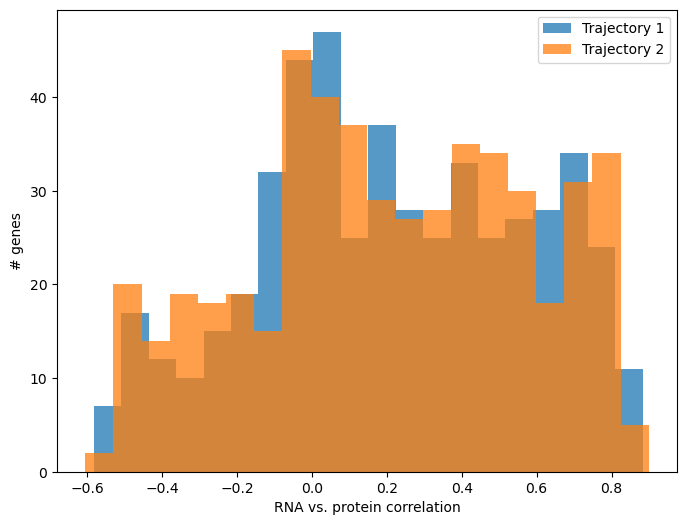

In [271]:
plt.figure(figsize=(8, 6))

for i in set(map(int, true_l)):
    plt.hist(data[f'Cor {i + 1}'], bins=20, label=f"Trajectory {i + 1}", alpha=0.75);

plt.xlabel("RNA vs. protein correlation");
plt.ylabel("# genes");
plt.legend();

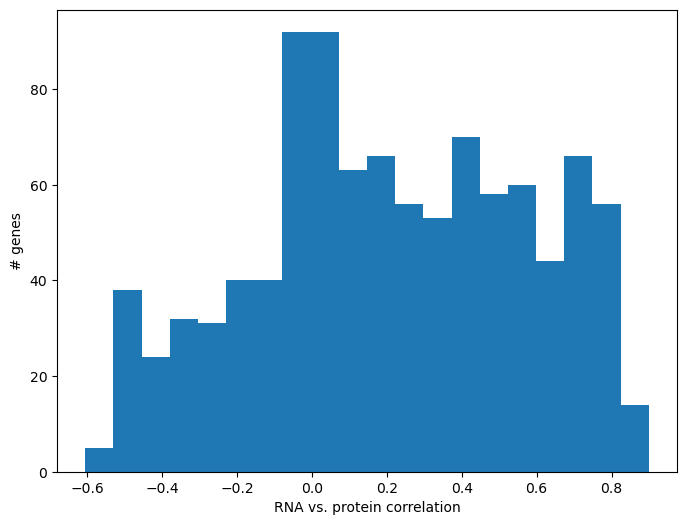

In [272]:
combined = []
for i in set(map(int, true_l)):
    combined.append(data[f'Cor {i + 1}'])
  
combined_data = pd.concat(combined, ignore_index=True)
 
plt.figure(figsize=(8, 6))
plt.hist(combined_data, bins=20)
plt.xlabel("RNA vs. protein correlation");
plt.ylabel("# genes");

## Show how correlation is calculated for each trajectory separately

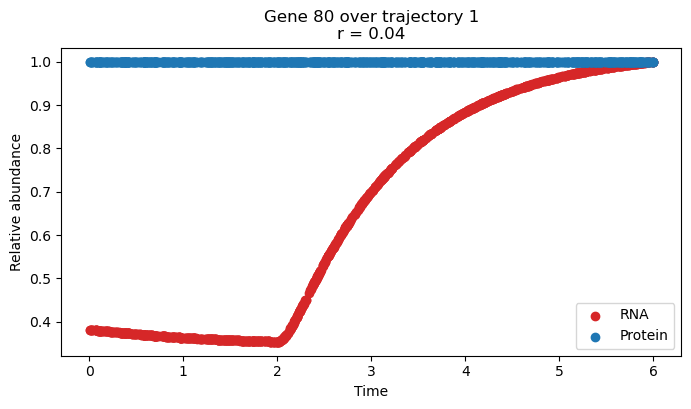

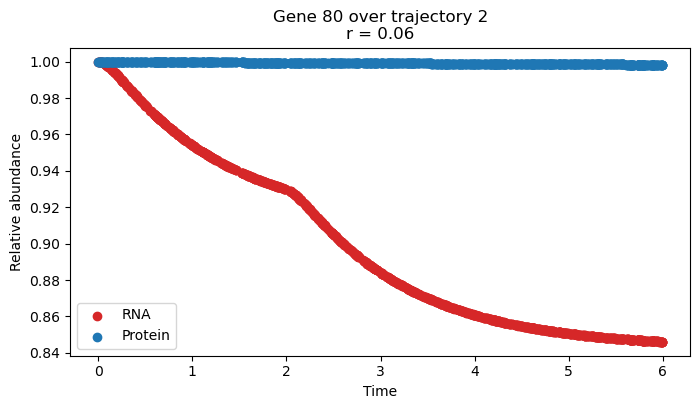

In [274]:
# Show how correlation is calculated for each trajectory separately

idx = 80
cor = round(data.iloc[idx]["Cor 1"], 2)

plt.figure(figsize=(8, 4))
plt.scatter(true_t[true_l == 0], Y[:n, idx, 1] / np.max(Y[:n, idx, 1]), color="tab:red", label="RNA")
plt.scatter(true_t[true_l == 0], P[:n, idx] / np.max(P[:n, idx]), color="tab:blue", label="Protein")
plt.title(f'Gene {idx} over trajectory 1\nr = {cor}')
plt.xlabel('Time')
plt.ylabel('Relative abundance')
plt.legend()
plt.show()

cor = round(data.iloc[idx]["Cor 2"], 2)

plt.figure(figsize=(8, 4))
plt.scatter(true_t[true_l == 1], Y[n:, idx, 1] / np.max(Y[n:, idx, 1]), color="tab:red", label="RNA")
plt.scatter(true_t[true_l == 1], P[n:, idx] / np.max(P[n:, idx]), color="tab:blue", label="Protein")
plt.title(f'Gene {idx} over trajectory 2\nr = {cor}')
plt.xlabel('Time')
plt.ylabel('Relative abundance')
plt.legend()
plt.show()

# PCA on genes (cells are features)

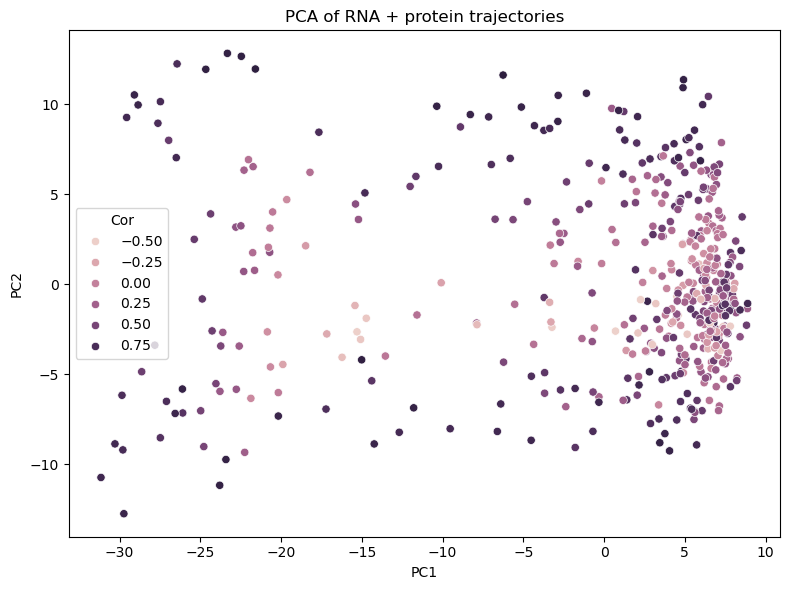

In [275]:
# PCA on genes (cells are features)

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Y_norm = Y_observed[:, :, 1] / np.max(Y_observed[:, :, 1], axis=0) # Normalize each cell's expression over genes (so certain higher expression cells don't dominate PCA)
P_norm = P_observed / np.max(P_observed, axis=0) # ...also don't want protein counts per cell to dominate over RNA

# Concatenate RNA and protein for PCA ===
combined_traj = np.concatenate([Y_norm, P_norm], axis=0)
pca = PCA(n_components=3)
traj_pca = pca.fit_transform(combined_traj.T)

kmeans = KMeans(n_clusters=3, random_state=0)
data['Cluster'] = kmeans.fit_predict(traj_pca)
data['PC1'] = traj_pca[:, 0]
data['PC2'] = traj_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=data, hue='Cor')
plt.title('PCA of RNA + protein trajectories')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='PC1', y='PC2', data=data, hue='Cluster', palette='Set2')
# plt.title('PCA of RNA + protein trajectories')
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.tight_layout()
# plt.show()

# custom_handles = [
#     Line2D([0], [0], marker='o', color='w', label='RNA', markerfacecolor='tab:red', markersize=10),  # big marker
#     Line2D([0], [0], marker='o', color='w', label='Protein', markerfacecolor='tab:blue', markersize=10), # small marker
#         ]
    
# print(data.groupby('Cluster').mean().sort_values('Cor'))

# # Plot representative gene trajectories from each cluster
# for c in sorted(data['Cluster'].unique()):
#     idx = data[data['Cluster'] == c].index[0]  # random gene in cluster
#     plt.figure(figsize=(8, 4))
#     plt.scatter(true_t[true_l == 0], Y[:n, idx, 1] / np.max(Y[:n, idx, 1]), color="tab:red")
#     plt.scatter(true_t[true_l == 0], P[:n, idx] / np.max(P[:n, idx]), color="tab:blue")
#     plt.title(f'Trajectory example - cluster {c} (gene {idx})')
#     plt.xlabel('Time')
#     plt.ylabel('Abundance')
#     plt.legend(handles=custom_handles)
#     plt.show()

In [278]:
# # PCA on genes with kinetic parameters as features

# alpha_cols = [f"Alpha {i}" for i in range(1, len(set(topo.flatten())))]
# theta_data = pd.DataFrame(theta, columns=["Steady_state", *alpha_cols, "Beta", "Gamma"])
# theta_data_norm = theta_data / np.max(theta_data, axis=0)
 
# protein_steady_state = (phi[:, 0]/phi[:, 1]).reshape(-1, 1)
# phi_data = pd.DataFrame(np.concatenate([protein_steady_state, phi], axis=1), columns=['Protein_steady_state', 'Translation_rate', 'Degradation_rate'])
# phi_data_norm = phi_data / np.max(phi_data, axis=0) 

# # Concatenate RNA and protein for PCA
# combined_traj = np.concatenate([theta_data_norm, phi_data_norm], axis=1)
# pca = PCA(n_components=3)
# traj_pca = pca.fit_transform(combined_traj)
# data['PC1'] = traj_pca[:, 0]
# data['PC2'] = traj_pca[:, 1]

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='PC1', y='PC2', data=data, hue='Cor')
# plt.title('PCA of RNA + protein trajectories')
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.tight_layout()
# plt.show()

# What are the highest/lowest correlation genes (over trajectory 1)?

In [279]:
# What are the highest/lowest correlation genes over trajectory 1?

data.sort_values(by="Cor 1")

,Cor,RNA_steady_state,Beta,Gamma,Protein_steady_state,Translation_rate,Degradation_rate,Alpha 1,Alpha 2,Alpha 3,Cor 1,Cor 2,Cluster,PC1,PC2
350,0.740551,0.535329,8.632742,2.313179,67266.565428,13.971974,0.000208,2.054707,0.218553,5.998662,-0.581873,0.763017,1,0.050805,0.078835
122,-0.404980,1.025848,6.881083,1.052634,5658.952839,40.424481,0.007143,1.338744,0.383387,0.756752,-0.551450,-0.373970,2,-0.072932,-0.114485
334,0.108876,0.199214,8.357099,2.833000,194.383481,2.100184,0.010804,3.947286,0.334368,3.397737,-0.535631,0.193566,1,0.173622,0.105027
116,-0.517914,0.645644,6.921897,1.458574,5529.508382,77.358414,0.013990,11.914592,0.408528,0.482967,-0.521187,-0.516101,2,0.503405,-0.331821
132,-0.068967,0.036237,19.069517,1.920644,759.594902,15.284889,0.020122,0.919396,0.041267,0.578919,-0.516652,0.013201,1,-0.225830,0.122837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.836214,1.094921,4.954039,0.550548,5533.686750,79.090605,0.014293,1.180963,8.436082,2.957363,0.837684,0.128473,2,-0.021484,-0.212604
224,0.858268,0.572230,5.483067,0.816091,7103.370201,6.426309,0.000905,0.288445,18.043040,0.899697,0.846924,0.034266,2,-0.033387,-0.164623
300,0.855105,0.466562,6.462363,1.016672,97.815458,8.122764,0.083042,0.160618,5.577973,2.185780,0.850438,0.776084,1,-0.105811,-0.113734
301,0.861675,0.410367,5.764370,0.693596,4845.435986,157.484661,0.032502,0.380565,3.062605,0.532769,0.855593,0.160024,1,-0.074858,-0.130800


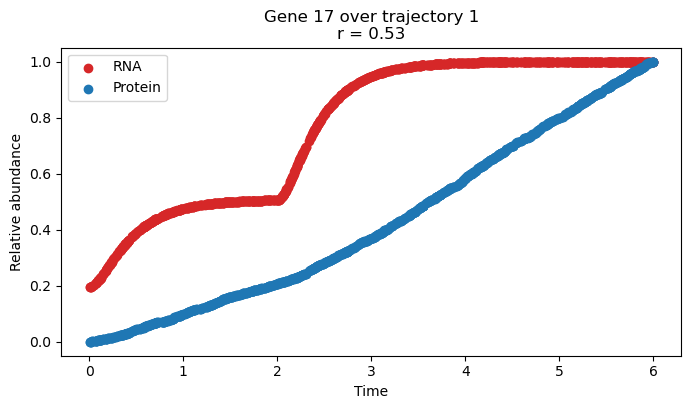

In [280]:
idx = 17
cor = round(data.iloc[idx]["Cor 1"], 2)

plt.figure(figsize=(8, 4))
plt.scatter(true_t[true_l == 0], Y[:n, idx, 1] / np.max(Y[:n, idx, 1]), color="tab:red", label="RNA")
plt.scatter(true_t[true_l == 0], P[:n, idx] / np.max(P[:n, idx]), color="tab:blue", label="Protein")
plt.title(f'Gene {idx} over trajectory 1\nr = {cor}')
plt.xlabel('Time')
plt.ylabel('Relative abundance')
plt.legend()
plt.show()

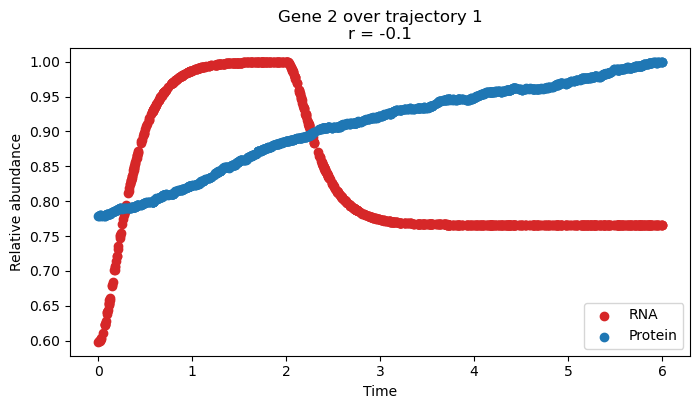

In [281]:
idx = 2
cor = round(data.iloc[idx]["Cor 1"], 2)

plt.figure(figsize=(8, 4))
plt.scatter(true_t[true_l == 0], Y[:n, idx, 1] / np.max(Y[:n, idx, 1]), color="tab:red", label="RNA")
plt.scatter(true_t[true_l == 0], P[:n, idx] / np.max(P[:n, idx]), color="tab:blue", label="Protein")
plt.title(f'Gene {idx} over trajectory 1\nr = {cor}')
plt.xlabel('Time')
plt.ylabel('Relative abundance')
plt.legend()
plt.show()

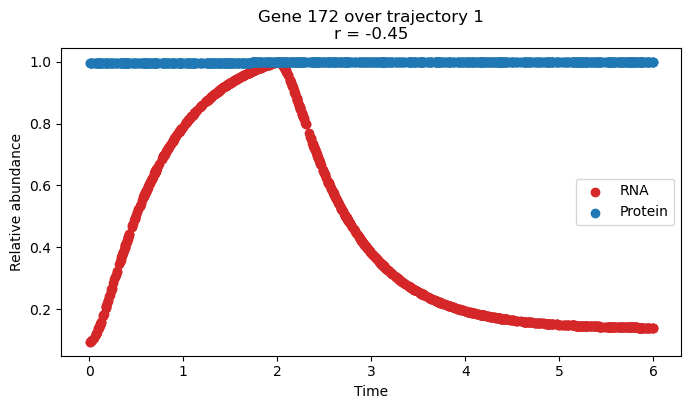

In [282]:
idx = 172
cor = round(data.iloc[idx]["Cor 1"], 2)

plt.figure(figsize=(8, 4))
plt.scatter(true_t[true_l == 0], Y[:n, idx, 1] / np.max(Y[:n, idx, 1]), color="tab:red", label="RNA")
plt.scatter(true_t[true_l == 0], P[:n, idx] / np.max(P[:n, idx]), color="tab:blue", label="Protein")
plt.title(f'Gene {idx} over trajectory 1\nr = {cor}')
plt.xlabel('Time')
plt.ylabel('Relative abundance')
plt.legend()
plt.show()

# Visualize parameters vs. correlation

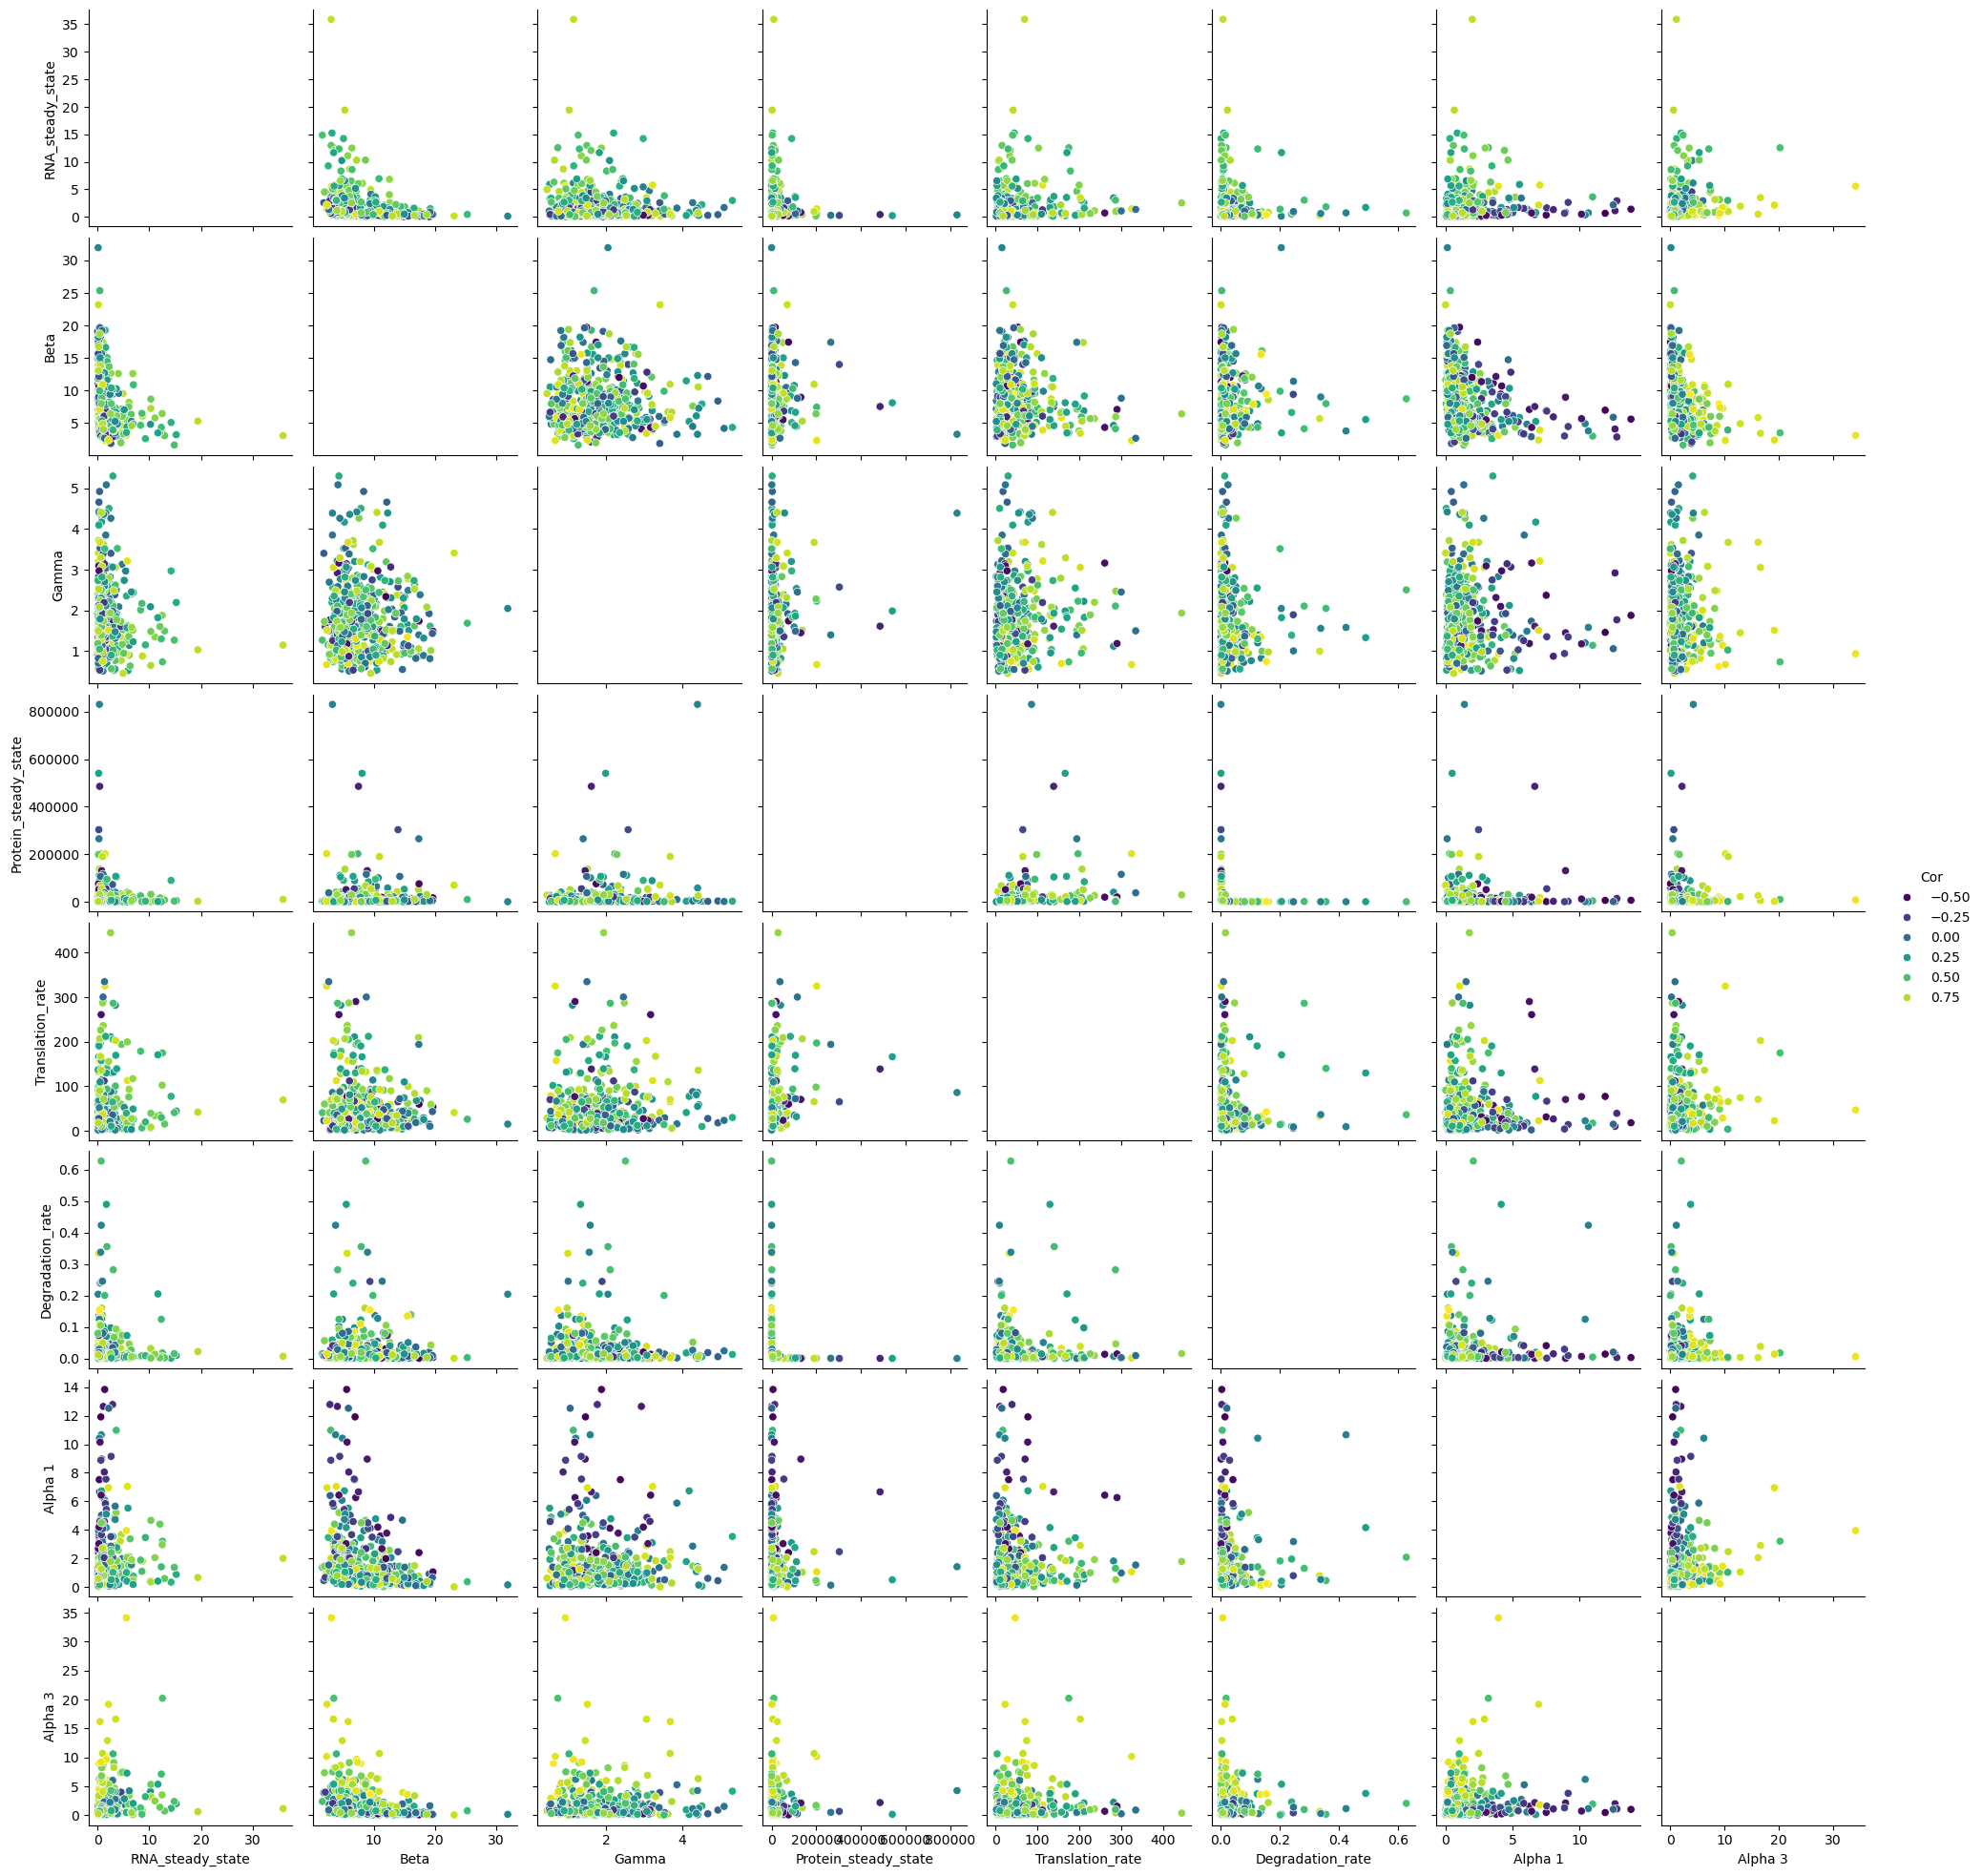

In [283]:
sns.pairplot(data, vars=param_cols, hue='Cor', palette='viridis')

# Modeling

In [284]:
data.columns

Index(['Cor', 'RNA_steady_state', 'Beta', 'Gamma', 'Protein_steady_state',
       'Translation_rate', 'Degradation_rate', 'Alpha 1', 'Alpha 2', 'Alpha 3',
       'Cor 1', 'Cor 2', 'Cluster', 'PC1', 'PC2'],
      dtype='object')

In [285]:
param_cols = list(data.columns.values[1:-5])

In [286]:
# Features to use for each trajectory

param_cols_traj1 = param_cols[:-1]
param_cols_traj2 = param_cols
param_cols_traj2.pop(-2);

In [287]:
# Data for each trajectory

X_traj1 = data[param_cols_traj1]
y_traj1 = data['Cor 1']

X_traj2 = data[param_cols_traj2]
y_traj2 = data['Cor 2']

In [289]:
# Split data into training and testing

X_traj1_train, X_traj1_test, y_traj1_train, y_traj1_test = train_test_split(X_traj1, y_traj1, test_size=0.2, random_state=random_seed)
X_traj2_train, X_traj2_test, y_traj2_train, y_traj2_test = train_test_split(X_traj2, y_traj2, test_size=0.2, random_state=random_seed)

## Random forest regression

In [301]:
X = data[param_cols]
y = data['Cor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_seed)

In [302]:
model = RandomForestRegressor(n_estimators=100, max_depth=len(param_cols), random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R²: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R²: 0.2304
Mean Squared Error: 0.0819


### Trajectory 1

In [292]:
model_traj1 = RandomForestRegressor(n_estimators=100, max_depth=len(param_cols_traj1), random_state=0)
model_traj1.fit(X_traj1_train, y_traj1_train)
y_traj1_pred = model_traj1.predict(X_traj1_test)

r2 = r2_score(y_traj1_test, y_traj1_pred)
mse = mean_squared_error(y_traj1_test, y_traj1_pred)

print(f"R²: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R²: 0.6586
Mean Squared Error: 0.0447


#### Feature importance

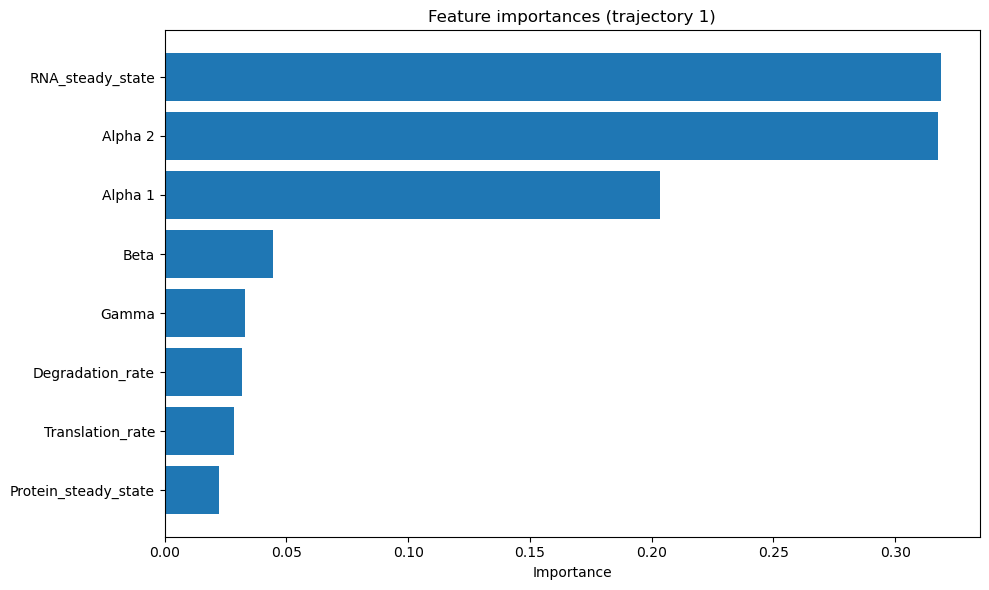

In [303]:
importances = model_traj1.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_traj1.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature importances (trajectory 1)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### PDP plots

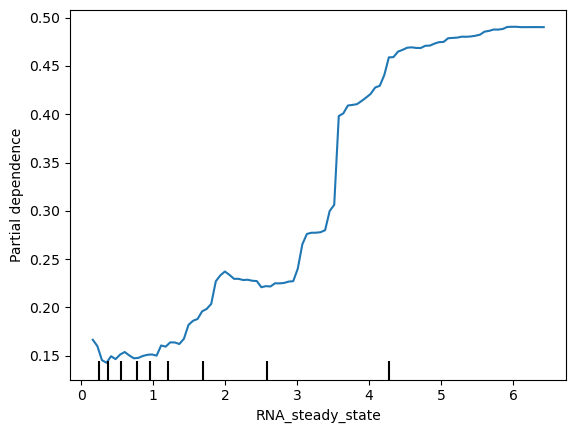

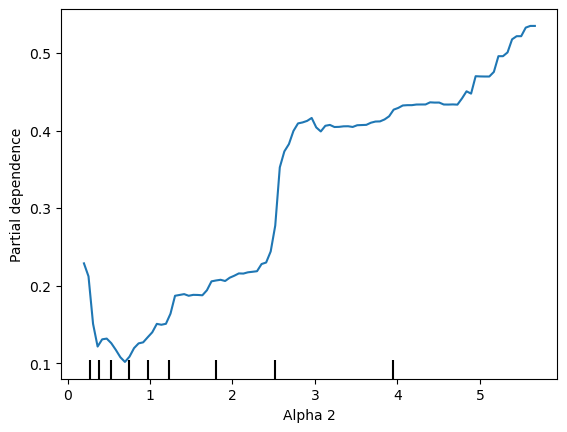

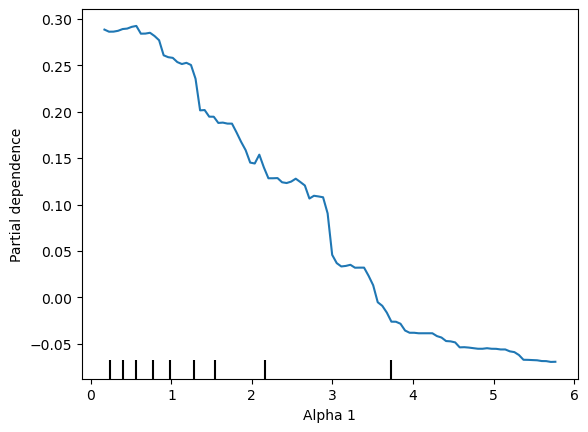

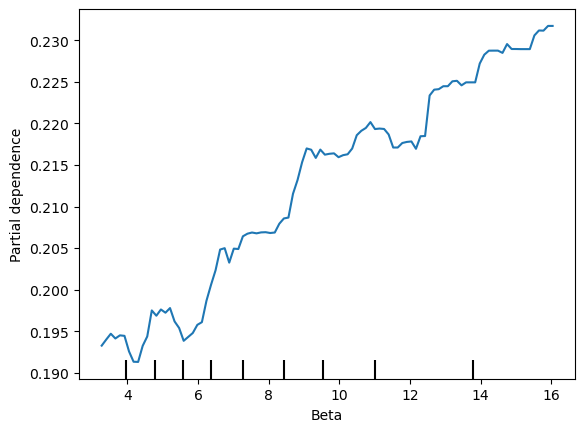

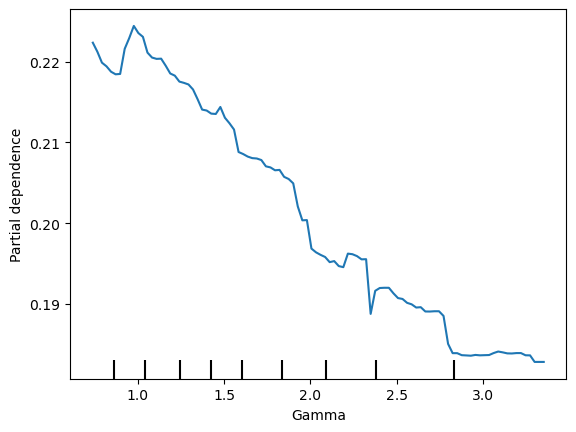

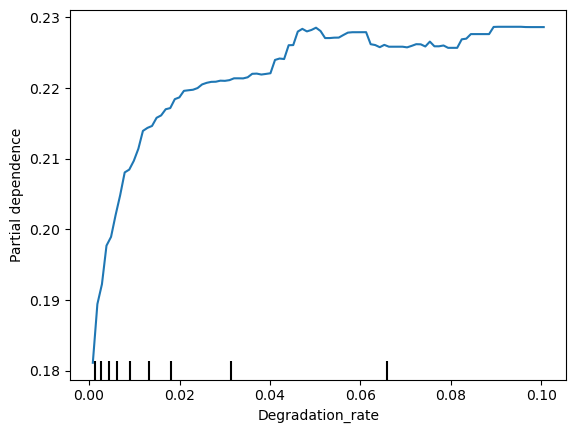

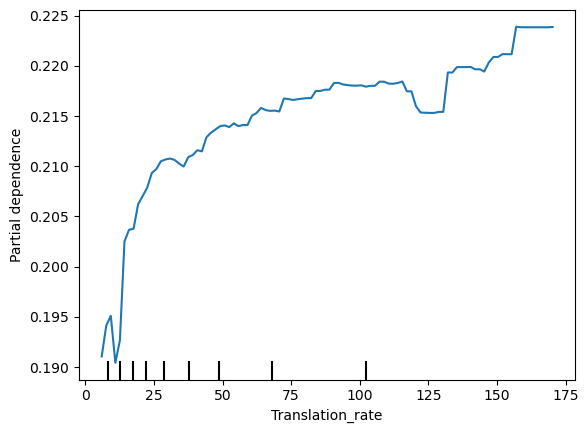

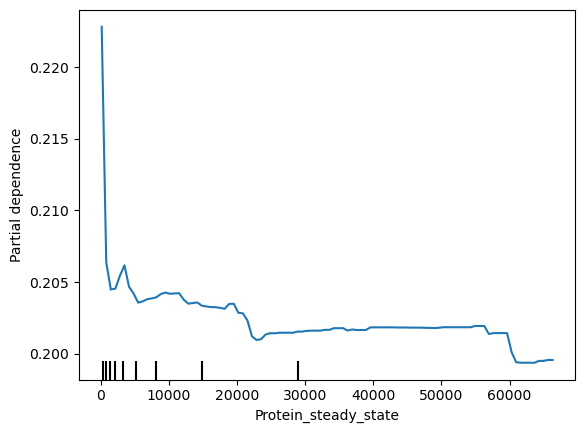

In [304]:
# PDP plots

for col in feature_importance_df['Feature']:
   PartialDependenceDisplay.from_estimator(model_traj1, X_traj1, features=[col]) 

In [ ]:

# # 4. Create SHAP explainer with new API
# explainer = shap.Explainer(model, X_train)
# shap_values = explainer(X_train)  # Explanation object

# # 5. Plot summary (beeswarm)
# shap.plots.beeswarm(shap_values, max_display=10)

# # 6. Plot dependence (e.g. Gamma vs Cor, colored by Translation_rate)
# shap.plots.scatter(shap_values[:, "Steady_state"], color=shap_values[:, "Alpha 1"])

# # 7. If you want bar plot of mean |SHAP| values:
# shap.plots.bar(shap_values, max_display=10)

### Trajectory 2

In [308]:
model_traj2 = RandomForestRegressor(n_estimators=100, max_depth=len(param_cols_traj2), random_state=0)
model_traj2.fit(X_traj2_train, y_traj2_train)
y_traj2_pred = model_traj2.predict(X_traj2_test)

r2 = r2_score(y_traj2_test, y_traj2_pred)
mse = mean_squared_error(y_traj2_test, y_traj2_pred)

print(f"R²: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R²: 0.5183
Mean Squared Error: 0.0670


#### Feature importance

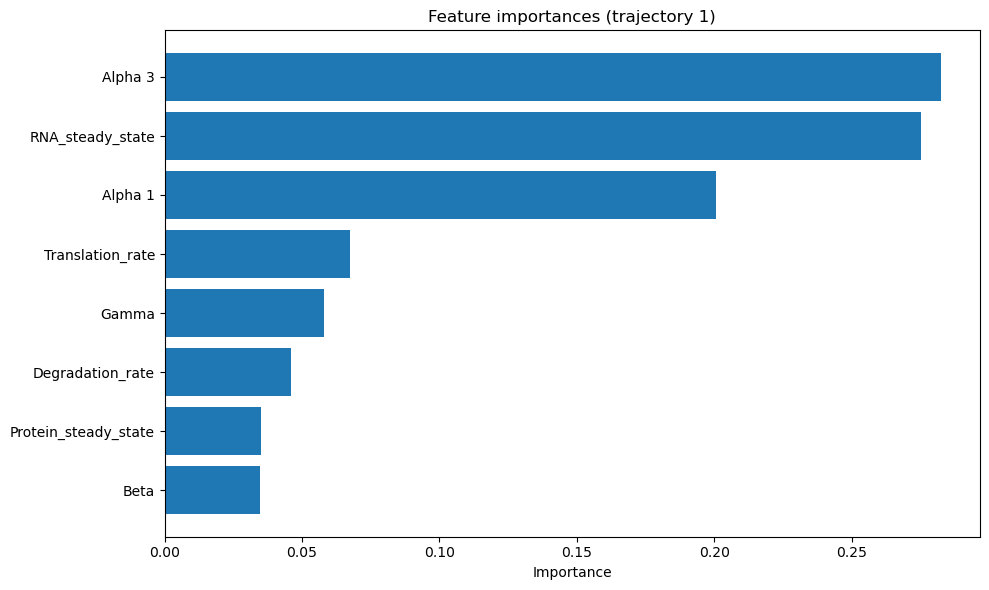

In [310]:
importances = model_traj2.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_traj2.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature importances (trajectory 1)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Linear regression

## Trajectory 1

In [305]:
# Generate polynomial interaction features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_traj1_train_poly = poly.fit_transform(X_traj1_train)
X_traj1_test_poly = poly.transform(X_traj1_test)

# Fit linear regression on polynomial features
model = LinearRegression()
model.fit(X_traj1_train_poly, y_traj1_train)

# Get interaction term names
feature_names = poly.get_feature_names_out(X_traj1.columns)  # X_traj1 must be a DataFrame
coeffs = pd.Series(model.coef_, index=feature_names).sort_values(key=abs, ascending=False)
print(coeffs.head(15))

# Make predictions
y_traj1_pred = model.predict(X_traj1_test_poly)

# Evaluate the model
mse = mean_squared_error(y_traj1_test, y_traj1_pred)
r2 = r2_score(y_traj1_test, y_traj1_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Degradation_rate                    -1.066652
RNA_steady_state Degradation_rate    0.213810
Degradation_rate Alpha 1             0.179668
Gamma Degradation_rate               0.156024
Beta Degradation_rate                0.103489
Alpha 2                              0.063748
Gamma                               -0.043744
Alpha 1                             -0.031870
RNA_steady_state                     0.022001
RNA_steady_state Alpha 1             0.014992
Gamma Alpha 2                       -0.013657
RNA_steady_state Alpha 2            -0.012741
Beta Alpha 1                        -0.009469
Translation_rate Degradation_rate   -0.007518
Beta Alpha 2                         0.005617
dtype: float64
Mean Squared Error: 0.0935456967420583
R-squared: 0.285354188430317


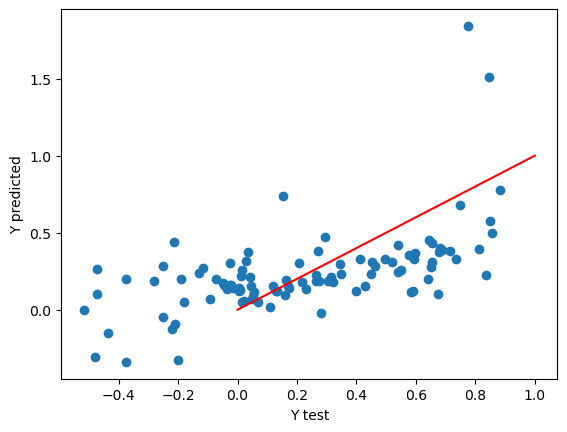

In [306]:
plt.scatter(y_traj1_test, y_traj1_pred)
plt.plot([0, 1], [0, 1], color='red')
plt.xlabel("Y test");
plt.ylabel("Y predicted");

## Trajectory 2

In [307]:
# Split data into training and testing
X_traj2_train, X_traj2_test, y_traj2_train, y_traj2_test = train_test_split(X_traj2, y_traj2, test_size=0.2, random_state=random_seed)

# Generate polynomial interaction features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_traj2_train_poly = poly.fit_transform(X_traj2_train)
X_traj2_test_poly = poly.transform(X_traj2_test)

# Fit linear regression on polynomial features
model = LinearRegression()
model.fit(X_traj2_train_poly, y_traj2_train)

feature_names = poly.get_feature_names_out(X_traj2.columns)
coeffs = pd.Series(model.coef_, index=feature_names).sort_values(key=abs, ascending=False)
print(coeffs.head(15))

# Make predictions
y_traj2_pred = model.predict(X_traj2_test_poly)

# Evaluate the model
mse = mean_squared_error(y_traj2_test, y_traj2_pred)
r2 = r2_score(y_traj2_test, y_traj2_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Degradation_rate                    -0.274752
Degradation_rate Alpha 1             0.214290
Gamma Degradation_rate              -0.207276
Degradation_rate Alpha 3            -0.198852
RNA_steady_state Degradation_rate    0.149849
Beta Degradation_rate                0.144678
Alpha 1                             -0.117198
Alpha 3                              0.079364
RNA_steady_state                     0.035593
Gamma Alpha 3                       -0.027504
RNA_steady_state Alpha 3            -0.019568
RNA_steady_state Alpha 1             0.017386
Gamma Alpha 1                        0.016483
Beta                                -0.013068
Gamma                               -0.008297
dtype: float64
Mean Squared Error: 0.11194667142194854
R-squared: 0.19489941545715772


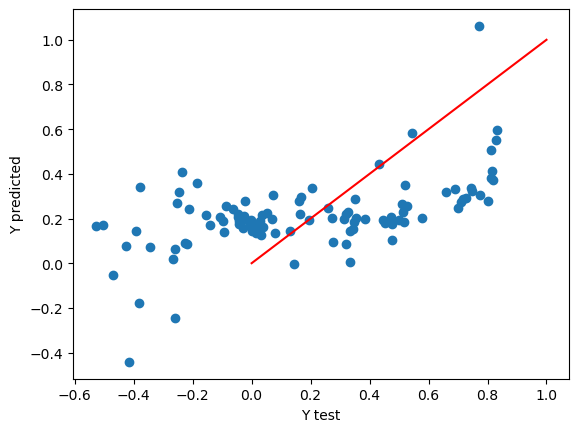

In [299]:
plt.scatter(y_traj2_test, y_traj2_pred)
plt.plot([0, 1], [0, 1], color='red')
plt.xlabel("Y test");
plt.ylabel("Y predicted");